#**Assignment 2: Implementation of Trust rank using Pregel framework.** 

Submitted by:

1. Nitish Kumar Gundapu **AI22MTECH14004** \\
2. Soumyanetra Pal **AI22MTECH14005** \\
3. Major Raviraj Deshmukh **AI22MTECH13008** \\
4. Vishnu Vijay Tiwari **AI22MTECH14003**

#1. Imports

In [ ]:
import os
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import threading
import time

import warnings
warnings.filterwarnings('ignore')

#2. Mount Dataset

In [ ]:
#Mount Google Drive to G-colab
def mountDrive():

  drive.mount('/content/drive')
  %cd ./drive/MyDrive/Trust_rank/
  
  print(os.listdir())

mountDrive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Trust_rank
['bad.csv', 'MAIL_TO_REG_STUD_214513_2077543_20230320_084441_078', '.ipynb_checkpoints', 'nodes.txt', 'Iron_dealers_data.csv', 'Trust_Rank.ipynb']


#3. Pregel

(Same as provided in class)

In [ ]:
class Vertex():
    def __init__(self,id,value,out_vertices,outgoing_messages=[]):
        self.id = id 
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = outgoing_messages
        self.active = True
        self.superstep = 0
   
class Pregel():
    def __init__(self,vertices,num_workers):
        self.vertices = vertices
        self.num_workers = num_workers

    def run(self):
        """Runs the Pregel instance."""
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_messages()

    def partition_vertices(self):
        """Returns a dict with keys 0,...,self.num_workers-1
        representing the worker threads.  The corresponding values are
        lists of vertices assigned to that worker."""
        partition = collections.defaultdict(list)
        for vertex in self.vertices:
            partition[self.worker(vertex)].append(vertex)
        return partition

    def worker(self,vertex):
        """Returns the id of the worker that vertex is assigned to."""
        return hash(vertex) % self.num_workers

    def superstep(self):
        """Completes a single superstep.  

        Note that in this implementation, worker threads are spawned,
        and then destroyed during each superstep.  This creation and
        destruction causes some overhead, and it would be better to
        make the workers persistent, and to use a locking mechanism to
        synchronize.  The Pregel paper suggests that this is how
        Google's Pregel implementation works."""
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """Updates the message lists for all vertices."""
        for vertex in self.vertices:
            vertex.superstep +=1
            vertex.incoming_messages = []
        for vertex in self.vertices:
            for (receiving_vertix,message) in vertex.outgoing_messages:
                receiving_vertix.incoming_messages.append((vertex,message))

    def check_active(self):
        """Returns True if there are any active vertices, and False
        otherwise."""
        return any([vertex.active for vertex in self.vertices])

class Worker(threading.Thread):

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()        

    def superstep(self):
        """Completes a single superstep for all the vertices in
        self."""
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()

#4. Pregel Pagerank

In [ ]:
"""
Implimentation of Pagerank using pregel framework
"""

from numpy import mat, eye, zeros, ones, linalg
import random

num_workers = 4          

""" Vertex class for Pagerank algorithm
    Can add instance varibles and methods according to algorithm
"""
class TrustRankVertex(Vertex):
    def __init__(self,id,value,out_vertices,outgoing_messages,num_vertices,dampingFactor=0.85,iterations=50):
        Vertex.__init__(self,id,value,out_vertices,outgoing_messages)
        self.num_vertices = num_vertices
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations

    def update(self):
        if self.superstep < self.num_supersteps:
            messages_sum = 0
            for (vertex,message) in self.incoming_messages:
                messages_sum = messages_sum+message
            self.value = (1-self.dampingFactor) / self.num_vertices + self.dampingFactor*messages_sum
            outgoing_message = self.value * (len(self.out_vertices)/num_edges)
            self.outgoing_messages = [(vertex,outgoing_message) for vertex in self.out_vertices]
        else:
            self.active = False


""" Get the list of graph nodes from file"""
def getNodes(filenm):
    with open(filenm,'r') as file:
        return [int(float(nd))for nd in file.readlines()]

""" Intialiaze value for each node
    For Trustrank it is same of all bad nodes : 1 / No of bad nodes
    It is zero for the good ones
"""
def intialPageRank(nodes, bad_nodes):
    return [1.0/len(bad_nodes) if n in bad_nodes else 0 for n in nodes]

def removeDuplicates(dealers):
  #Eliminating Self Loops if any
  dealers = dealers[(dealers['Seller ID']!=dealers['Buyer ID'])]

  data = []

  # Collapse all paths to one in case of multiple paths from p -> q
  disticnt_sources = dealers['Seller ID'].unique()
  for source in disticnt_sources:
    transactions = dealers[(dealers['Seller ID'] == source)]
    distinct_dest = transactions['Buyer ID'].unique()
    for dest in distinct_dest:
      deals = transactions[(transactions['Buyer ID'] == dest)]
      sum = deals['Value'].sum()
      if(sum != 0):
        data.append([source, dest, sum])

  final_data = pd.DataFrame(data, columns =['Seller ID', 'Buyer ID', "Value"])

  print(f'Unique Transactions: {final_data.shape[0]}')

  #Sanity Check
  f = final_data.drop('Value', axis=1)
  print(f'Number of Duplicate Transactions: {len(f[f.duplicated()])}')
  return final_data

""" Updating out going vertices for each vertex using edges """
def updateOutGoingVertices(vertices,dealers, bad_nodes):
    edges = 0
    
    sellers,buyers = dealers['Seller ID'], dealers['Buyer ID']
    for frm, to in zip(sellers,buyers):
      for v in vertices:
          for u in vertices:
              if v.id == frm and u.id == to:
                  v.out_vertices.append(u)
                  edges+=1
          
          #Connect to all bad nodes incase of a dangling node
          if(len(v.out_vertices) == 0):
            for u in vertices:
              if u.id in bad_nodes:
                v.out_vertices.append(u)
                edges+=1
    return edges

""" Compute Pagerank using pregel by assigning set of vertices to thread """
def pregelTrustrank(vertices):
    p = Pregel(vertices,num_workers)
    p.run()
    return mat([vertex.value for vertex in p.vertices]).transpose()


#5. Fetch Data

In [ ]:
# Read Transaction details
edge_file="Iron_dealers_data.csv"
dealers = removeDuplicates(pd.read_csv(edge_file))

nodes = [*dealers['Seller ID'], *dealers['Buyer ID']]
nodes = pd.DataFrame(nodes)[0].unique()

# Read Unique nodes
nodes_file = "nodes.txt"
myFile = open('./'+nodes_file, 'w+')
np.savetxt(myFile, nodes)
myFile.close()

nodes = getNodes(nodes_file)                  
num_vertices = len(nodes)

# Read known bad nodes
bad_nodes = pd.read_csv('bad.csv')['Bad Id'].to_numpy()

Unique Transactions: 5358
Number of Duplicate Transactions: 0


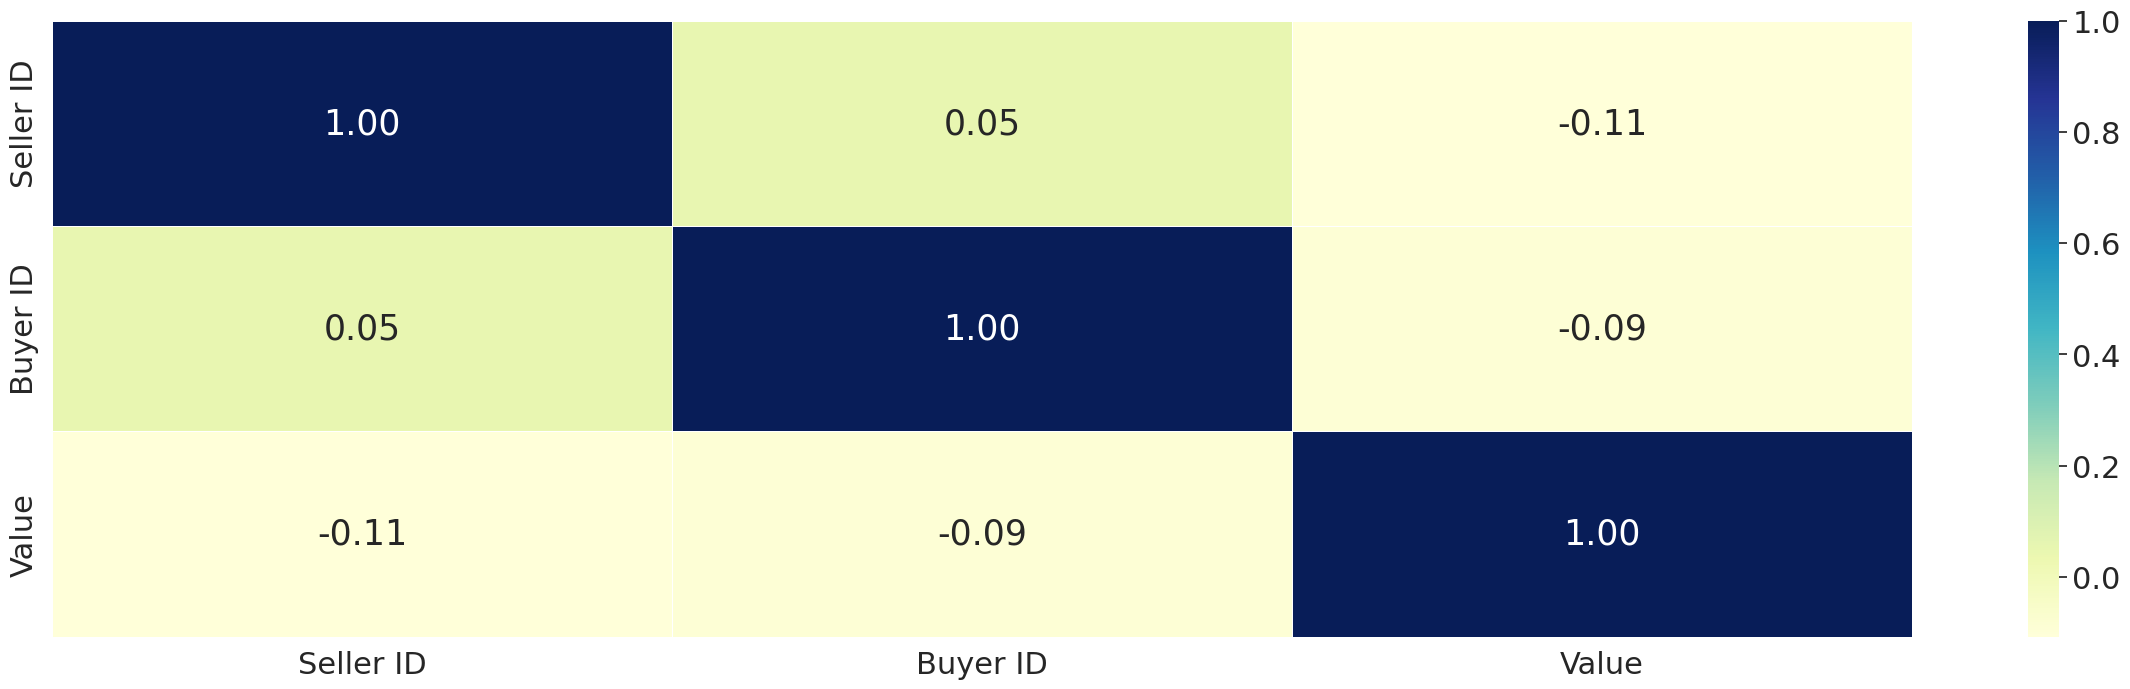

In [ ]:
data = dealers
correlation_train = data.corr("pearson")
sns.set(font_scale=2)
fig = plt.figure(figsize=(30, 8))
ax = sns.heatmap(
    correlation_train,
    annot=True,
    annot_kws={"size": 25},
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
)
fig.show()


#6. Run Page Rank

In [ ]:
# Intial ranks of nodes in the order of nodes
nodes_intial_ranks = intialPageRank(nodes, bad_nodes)     

# Intialize the vertices with modified Vertex class
vertices = []
for i in range(len(nodes)):
    v = dealers[(dealers['Seller ID'] == nodes[i])]['Value'].to_numpy()
    vertices.append(TrustRankVertex(nodes[i],nodes_intial_ranks[i],[],v,num_vertices,0.85,50))

# Updating vertex out vertices to send the messages
num_edges = updateOutGoingVertices(vertices,dealers, bad_nodes)
print(f'Number of Edges: {num_edges}')

#Trustrank computation
node_ranks = pregelTrustrank(vertices)

Number of Edges: 21318


#7. Verify if the code recognises the known bad nodes

In [ ]:
node_ranks = np.array(node_ranks).reshape(len(node_ranks))
idx = np.argsort(-node_ranks)
sorted_nodes=np.array(nodes)[idx]

# Checking top 20 bad nodes
count = 0
for node in sorted_nodes[:20]:
  if(node in bad_nodes):
    count +=1

print(f'Number of matches of Top 20 Predicted Frauds in the given Fraud list: {count}')

Number of matches of Top 20 Predicted Frauds in the given Fraud list: 20


#8. Distribution of the Trust Scores

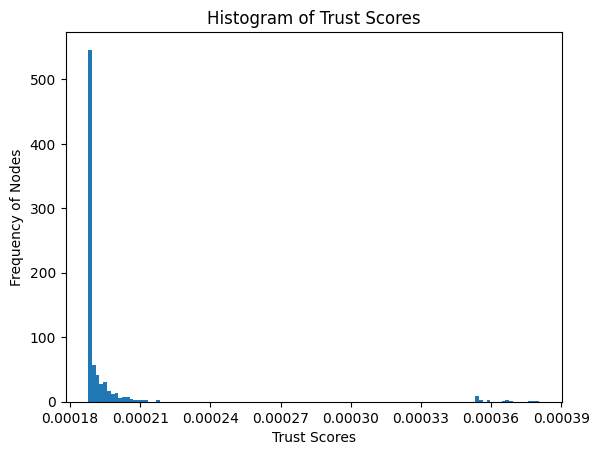

In [ ]:
plt.hist(node_ranks, bins=120) 
plt.xticks([(i/100000) for i in range(18,40,3)])
plt.xlabel('Trust Scores')
plt.ylabel('Frequency of Nodes')
plt.title('Histogram of Trust Scores')
plt.show()

#9. Scores Assigned to each nodes

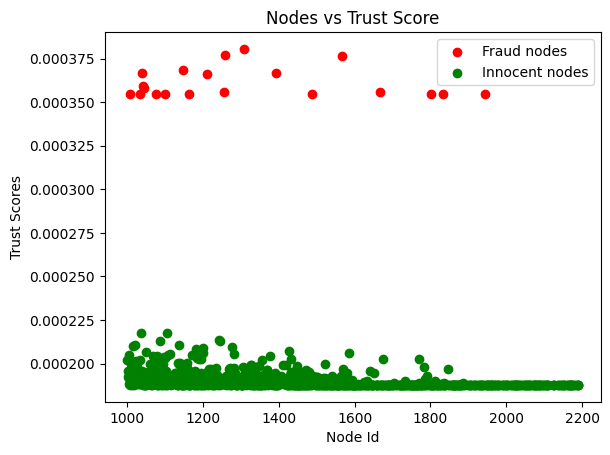

In [ ]:
sorted_ranks = node_ranks[idx]
fraud_node_ranks = sorted_ranks[:20]
good_node_ranks = sorted_ranks[20:]
good_nodes = sorted_nodes[20:]
plt.scatter(bad_nodes, fraud_node_ranks, c='r', label='Fraud nodes')
plt.scatter(good_nodes, good_node_ranks, c='g', label='Innocent nodes')
plt.title('Nodes vs Trust Score')
plt.xlabel('Node Id')
plt.ylabel('Trust Scores')
plt.legend()
plt.show()